In [18]:
# Jupyter Notebook cell 1: Imports

import yfinance as yf
import numpy as np
from datetime import datetime
from math import log, sqrt, exp
from scipy.stats import norm
import matplotlib.pyplot as plt

In [19]:
# Jupyter Notebook cell 2: Black–Scholes Formulas

def black_scholes_call(S, K, T, r, sigma):
    """
    Black-Scholes price of a European Call.
    
    S: Current underlying price
    K: Strike price
    T: Time to maturity (in years)
    r: Risk-free interest rate (annualized, decimal form)
    sigma: Volatility (annualized, decimal form)
    """
    if T <= 0 or sigma <= 0:
        # Extremely rough edge case
        return max(0.0, S - K)
    
    d1 = (log(S/K) + (r + 0.5*sigma**2)*T) / (sigma * sqrt(T))
    d2 = d1 - sigma*sqrt(T)
    
    call_price = S * norm.cdf(d1) - K * exp(-r*T) * norm.cdf(d2)
    return call_price


def black_scholes_put(S, K, T, r, sigma):
    """
    Black-Scholes price of a European Put.
    
    S: Current underlying price
    K: Strike price
    T: Time to maturity (in years)
    r: Risk-free interest rate (annualized, decimal form)
    sigma: Volatility (annualized, decimal form)
    """
    if T <= 0 or sigma <= 0:
        # Extremely rough edge case
        return max(0.0, K - S)
    
    d1 = (log(S/K) + (r + 0.5*sigma**2)*T) / (sigma * sqrt(T))
    d2 = d1 - sigma*sqrt(T)
    
    put_price = K * exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return put_price


In [20]:
# Jupyter Notebook cell 3: Implied Vol Solvers (Newton–Raphson)

def implied_vol_call(market_price, S, K, T, r=0.0, tol=1e-6, max_iter=100):
    """
    Newton-Raphson to find implied volatility for a European Call.
    market_price: Observed market price (bid/ask mid or last)
    S, K, T, r: Underlying price, strike, time-to-expiry, risk-free rate
    """
    # Intrinsic value for a call is max(0, S - K*exp(-r*T))
    intrinsic_value = max(0.0, S - K*exp(-r*T))
    if market_price < intrinsic_value:
        return np.nan  # Impossible if below intrinsic
    
    sigma = 0.3  # initial guess
    for _ in range(max_iter):
        price_guess = black_scholes_call(S, K, T, r, sigma)
        diff = price_guess - market_price
        
        if abs(diff) < tol:
            return sigma
        
        # Vega: partial derivative wrt sigma
        d1 = (log(S/K) + (r + 0.5*sigma**2)*T) / (sigma * sqrt(T))
        vega = S * norm.pdf(d1) * sqrt(T)
        
        if vega < 1e-8:  # avoid division by near-zero
            break
        
        sigma -= diff / vega
        if sigma < 1e-8:
            sigma = 1e-8
    
    return sigma


def implied_vol_put(market_price, S, K, T, r=0.0, tol=1e-6, max_iter=100):
    """
    Newton-Raphson to find implied volatility for a European Put.
    market_price: Observed market price (bid/ask mid or last)
    S, K, T, r: Underlying price, strike, time-to-expiry, risk-free rate
    """
    # Intrinsic value for a put is max(0, K*exp(-r*T) - S)
    intrinsic_value = max(0.0, K*exp(-r*T) - S)
    if market_price < intrinsic_value:
        return np.nan
    
    sigma = 0.3  # initial guess
    for _ in range(max_iter):
        price_guess = black_scholes_put(S, K, T, r, sigma)
        diff = price_guess - market_price
        
        if abs(diff) < tol:
            return sigma
        
        d1 = (log(S/K) + (r + 0.5*sigma**2)*T) / (sigma * sqrt(T))
        vega = S * norm.pdf(d1) * sqrt(T)
        
        if vega < 1e-8:
            break
        
        sigma -= diff / vega
        if sigma < 1e-8:
            sigma = 1e-8
    
    return sigma


In [21]:
# Jupyter Notebook cell 4: Get Risk-Free Rate from T-Bill

def get_risk_free_rate():
    """
    Fetches the 3-month T-bill (annualized) yield from yfinance
    using the '^IRX' ticker. You can switch to a different T-Bill
    if you prefer e.g. '^IRX' -> 3-month, '^FVX' -> 5-year, etc.
    
    Returns the yield in decimal form (e.g. 0.045 => 4.5%).
    """
    tbill = yf.Ticker("^IRX")  # 13-week T-bill index on Yahoo
    hist = tbill.history(period="1d")
    if hist.empty:
        # Fallback if no data
        return 0.042
    
    last_close = hist["Close"].iloc[-1]
    # Convert to decimal form (e.g. 4.5 => 0.045)
    r_decimal = last_close / 100.0
    return r_decimal


In [22]:
# Jupyter Notebook cell 5: Get Option Data
# Modified to use up to 3 expirations instead of just the first one.

def get_option_data(ticker_str, contract_type="calls"):
    """
    Retrieves up to 3 option chain DataFrames (calls or puts) for a given ticker's earliest expirations.
    
    contract_type: 'calls' or 'puts'
    Returns:
      - A list of tuples: [(options_df, T), (options_df, T), (options_df, T)] for up to 3 expirations
      - Underlying spot price S
    """
    ticker = yf.Ticker(ticker_str)
    
    # Get all available expiration dates
    expirations = ticker.options
    if not expirations:
        raise ValueError(f"No option data available for ticker {ticker_str}.")
    
    # Select up to the first 3 expiration dates
    selected_expirations = expirations[:500]
    
    # Get current underlying price
    stock_data = ticker.history(period="1d")
    if stock_data.empty:
        raise ValueError("Could not retrieve stock price history.")
    S = stock_data["Close"].iloc[-1]
    
    # Build a list of (DataFrame, T) for each of the selected expirations
    data_list = []
    now = datetime.now()
    
    for expiry_date in selected_expirations:
        chain = ticker.option_chain(expiry_date)
        if contract_type == "calls":
            options_df = chain.calls
        elif contract_type == "puts":
            options_df = chain.puts
        else:
            raise ValueError("contract_type must be either 'calls' or 'puts'.")
        
        expiry_dt = datetime.strptime(expiry_date, "%Y-%m-%d")
        T = (expiry_dt - now).days / 365.0
        
        # Skip if T <= 0
        if T > 0:
            data_list.append((options_df, T))
    
    return data_list, S


In [23]:
# Jupyter Notebook cell 6: Compute Implied Vols for All Contracts
# Modified to filter out NaN implied volatilities and combine data from up to 3 expirations.

def compute_implied_vols(ticker_str, contract_type="calls"):
    """
    Main function to:
      1. Get the risk-free rate from T-Bill yield.
      2. Retrieve up to 3 earliest expiration DataFrames (calls or puts).
      3. Compute implied volatility for each contract.
      4. Switch the moneyness formula:
         - For calls: moneyness = S / K
         - For puts:  moneyness = K / S
      5. Filter out any contracts that return NaN IV.
      6. Return arrays for implied vol, moneyness, and time-to-expiry.
    """
    # Step 1: Risk-free rate from T-Bill
    r = get_risk_free_rate()
    
    # Step 2: Get up to 3 option data sets
    data_list, S = get_option_data(ticker_str, contract_type=contract_type)
    
    ivs = []
    mny = []
    ttes = []
    
    # Step 3: Loop over each (DataFrame, time-to-expiry) pair
    for options_df, T in data_list:
        for _, row in options_df.iterrows():
            K = row["strike"]
            
            # Mid-price from bid/ask if possible
            bid = row.get("bid", np.nan)
            ask = row.get("ask", np.nan)
            if not np.isnan(bid) and not np.isnan(ask):
                market_price = 0.5 * (bid + ask)
            else:
                market_price = row.get("lastPrice", np.nan)
            
            if np.isnan(market_price):
                continue  # skip if we have no usable price
            
            # Compute implied vol for call or put
            if contract_type == "calls":
                iv = implied_vol_call(market_price, S, K, T, r=r)
                money = S / K  # Moneyness for calls
            else:
                iv = implied_vol_put(market_price, S, K, T, r=r)
                money = K / S  # Moneyness for puts
            
            # Filter out any NaN implied vol
            if np.isnan(iv):
                continue
            
            ivs.append(iv)
            mny.append(money)
            ttes.append(T)
    
    return ivs, mny, ttes


In [24]:
# Jupyter Notebook cell 7: Example Usage

# Choose a ticker symbol
ticker_symbol = "AAPL"

# Compute implied vols, moneyness, time-to-expiry for CALLS
ivs_calls, mny_calls, ttes_calls = compute_implied_vols(ticker_symbol, contract_type="calls")

print("CALLS:")
print("Implied Volatilities:", ivs_calls)
print("Moneyness (S/K):", mny_calls)
print("Time to Expiration (years):", ttes_calls)

print("-"*60)

# Compute implied vols, moneyness, time-to-expiry for PUTS
ivs_puts, mny_puts, ttes_puts = compute_implied_vols(ticker_symbol, contract_type="puts")

print("PUTS:")
print("Implied Volatilities:", ivs_puts)
print("Moneyness (K/S):", mny_puts)
print("Time to Expiration (years):", ttes_puts)


CALLS:
Implied Volatilities: [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 827040.2136325614, 101725.6183571046, 2916.485855141354, 293.27040522959834, 1e-08, 0.6377603446445339, 0.565871149388399, 0.5073900556931948, 0.4595423476333842, 0.42068741820683164, 0.39682991949453544, 0.37765072861777566, 0.358631520645213, 0.3460988978461822, 0.3431213050998204, 0.34301043106588325, 0.3444035799432438, 0.3673495000400956, 0.40216229545790516, 0.4254348074684854, 0.47196947737009926, 0.46343683263604196, 1e-08, 878.5245739219343, 9210.86920352666, 113081.93059443333, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 6753719.829754448, 69378.72573428959, 3567.886935014021, 246.0675948065398, 0.5471989929405328, 0.5533387436591068, 0.4253934648847116, 0.3686330278726342, 0.35770499208829126, 0.32859245041852025, 0.31

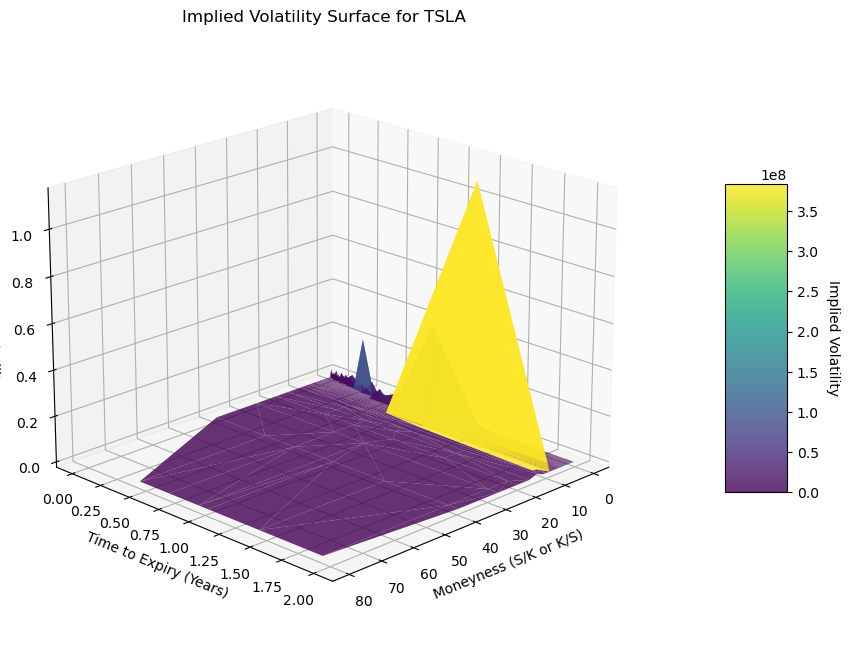

In [25]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.interpolate import griddata

# Combined data
ivs = np.array(ivs_calls + ivs_puts)
mny = np.array(mny_calls + mny_puts)
ttes = np.array(ttes_calls + ttes_puts)

# Create grid data for interpolation
grid_mny, grid_ttes = np.meshgrid(
    np.linspace(min(mny), max(mny), 100),
    np.linspace(min(ttes), max(ttes), 100)
)
grid_ivs = griddata((mny, ttes), ivs, (grid_mny, grid_ttes), method='cubic')

fig = plt.figure(figsize=(12, 8), dpi=100)
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(grid_mny, grid_ttes, grid_ivs, cmap='viridis', edgecolor='none', alpha=0.8)

# Customize the color bar
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, pad=0.1)
cbar.set_label("Implied Volatility", rotation=270, labelpad=15)

# Set axis labels and limits
ax.set_xlabel("Moneyness (S/K or K/S)")
ax.set_ylabel("Time to Expiry (Years)")
ax.set_zlabel("Implied Volatility")

# Set axis limits for better scaling
ax.set_xlim(min(mny), max(mny))
ax.set_ylim(min(ttes), max(ttes))
ax.set_zlim(min(ivs), max(ivs))

# Set a better viewing angle
ax.view_init(elev=30, azim=120)

# Add a grid for better readability
ax.grid(True)

plt.title(f"Implied Volatility Surface for {ticker_symbol}")

plt.tight_layout()
plt.show()